## calc de gradient vector for a cavity

In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using Bio
using MIToS.PDB
set_default_plot_size(28cm, 16cm)

In [2]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

## mto

In [72]:
# Preparo variables
aa3 = 360
aa = 120
natom_res = Array{Int64}(1);
modo_sum = Array{Float64}(aa, 3);
# indices de Calphas incluidos en el PCA
range_mto = collect(6:125)
range_mto_3 = map(x -> x*3, repeat(range_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(range_mto)]);
# indices de atomos correspondientes a los Calphas incluidos en el PCA
range_atom_mto = collect(127:2063)
range_atom_mto_3 = map(x -> x*3, repeat(range_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(range_atom_mto)]);
# indices de atomos descartados
head_atom_mto = collect(1:126)
tail_atom_mto = collect(2064:2128)
head_atom_mto_3 = map(x -> x*3, repeat(head_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(head_atom_mto)]);
tail_atom_mto_3 = map(x -> x*3, repeat(tail_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(tail_atom_mto)]);
# Arrays p/ guardar volumenes de pockets
vol_pocket_mto_1 = Array{Float64}(aa3-6);
vol_pocket_mto_2 = Array{Float64}(aa3-6);
vol_pocket_mto_3 = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_mto, evals_mto = read_ptraj_modes("/home/german/labo/16/hemo/run/mto/pca/modes_mto", aa3);

# Leo el pdb
mto_pdb = read("/home/german/labo/16/hemo/cavities/2displ/bu/mto.pdb", PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(mto_pdb)#size(modes_mto)[2]
    push!(natom_res, length(mto_pdb[i]))
end
shift!(natom_res)
# Me quedo con los residuos q me importan. Van del 6 al 125, pero en 'natom_res' no están incluidos los caps
# ni el hemo, por eso cambian los indices
natom_res_full = natom_res
natom_res = natom_res[4:123];

# Voy a usar esto p/ poner la matriz a sumar en el mismo formato q las coordenadas
head_mto = repmat([0.0 0.0 0.0], natom_res_full[1]+natom_res_full[2]+natom_res_full[3], 1)
tail_mto = repmat([0.0 0.0 0.0], natom_res_full[124]+natom_res_full[125]+natom_res_full[126]+natom_res_full[127], 1)

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/2displ/mto/"

"/home/german/labo/16/hemo/cavities/2displ/mto/"

In [104]:
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
# Preparo variables
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_mto[i*3-2, j]
            modo_sum[i, 2] = modes_mto[i*3-1, j]
            modo_sum[i, 3] = modes_mto[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)

        end
# Listo, ahora le doy el formato final
        modo_sum = [head_mto; temp1_modo_sum; tail_mto];

# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * (1 / evals_mto[j])
# Modifico las coordenadas
        mto_atom_xyz = coordinatesmatrix(mto_pdb)
        new_mto_atom_xyz = mto_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mto_pdb = change_coordinates(mto_pdb, new_mto_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
        write(pdb_mto, new_mto_pdb, PDBFile)
        
# Calculo el pocket
        conf_mto = string(files_template, displacement, "/conf_mto")
        vol_mto = string(files_template, displacement, "/vol_mto")
        run(`epock -s $pdb_mto -c $conf_mto -o $vol_mto`)
        rtdo = readdlm(vol_mto)
        vol_pocket_mto_1[j] = rtdo[2, 2]
        vol_pocket_mto_2[j] = rtdo[2, 3]
        vol_pocket_mto_3[j] = rtdo[2, 4]
    end
end

# Calculo el pocket original
pdb_mto = "/home/german/labo/16/hemo/cavities/2displ/bu/mto.pdb"
conf_mto = "/home/german/labo/16/hemo/cavities/2displ/mto/d1/conf_mto"
vol_mto = "/home/german/labo/16/hemo/cavities/2displ/mto/vol.dat"
run(`epock -s $pdb_mto -c $conf_mto -o $vol_mto`)
rtdo = readdlm(vol_mto)
orig_vol_pocket_mto_1 = rtdo[2, 2]
orig_vol_pocket_mto_2 = rtdo[2, 3]
orig_vol_pocket_mto_3 = rtdo[2, 4]

# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_mto_1 = (vol_pocket_mto_1 .- orig_vol_pocket_mto_1).^2
vec_pocket_mto_2 = (vol_pocket_mto_2 .- orig_vol_pocket_mto_2).^2
vec_pocket_mto_3 = (vol_pocket_mto_3 .- orig_vol_pocket_mto_3).^2;

# Los guardo
writedlm("/home/german/labo/16/hemo/cavities/2displ/vtores/vec_pocket_mto_corto", vec_pocket_mto_1)
writedlm("/home/german/labo/16/hemo/cavities/2displ/vtores/vec_pocket_mto_portal", vec_pocket_mto_2)
writedlm("/home/german/labo/16/hemo/cavities/2displ/vtores/vec_pocket_mto_largo", vec_pocket_mto_3);

354-element Array{Float64,1}:
 15.0544
 87.9844
  6.25  
 76.7376
  9.7969
 30.25  
  1.8769
  3.0976
  1.2544
 18.1476
 12.25  
  7.5076
  3.5344
  ⋮     
  0.3969
  0.0169
  0.0144
  0.0   
  0.3969
  0.0576
  0.1444
  1.2544
  0.25  
  0.7569
  1.0   
  0.0   

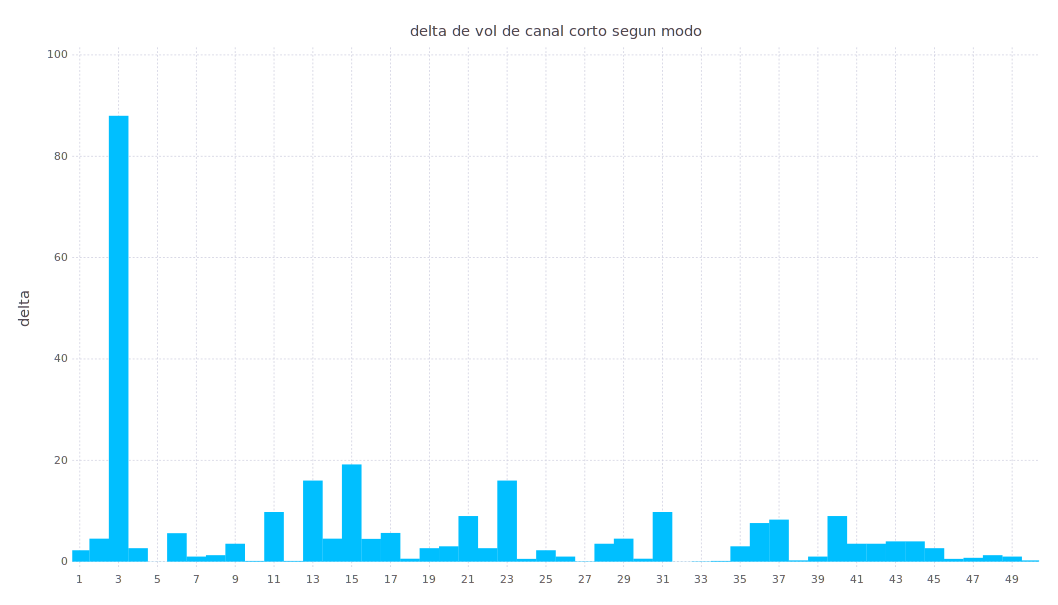

In [113]:
df_vec_pocket_mto_1 = DataFrame(delta = vec_pocket_mto_1)
plot(df_vec_pocket_mto_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo"),
Coord.Cartesian(xmin=1, xmax=50),
Guide.xticks(ticks = collect(1:2:50), orientation=:horizontal))

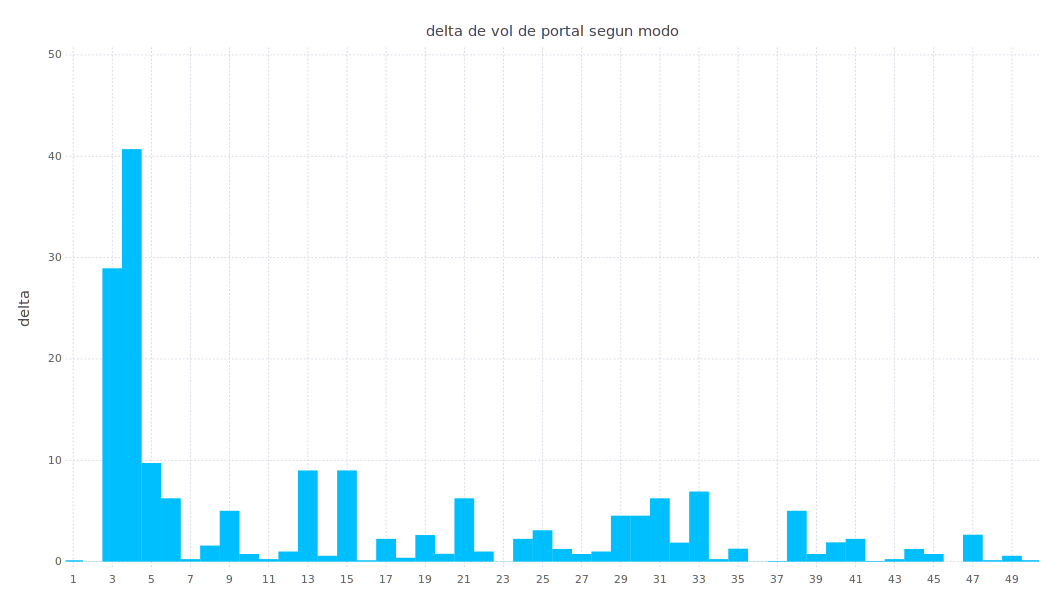

In [114]:
df_vec_pocket_mto_2 = DataFrame(delta = vec_pocket_mto_2)
plot(df_vec_pocket_mto_2,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de portal segun modo"),
Coord.Cartesian(xmin=1, xmax=50),
Guide.xticks(ticks = collect(1:2:50), orientation=:horizontal))

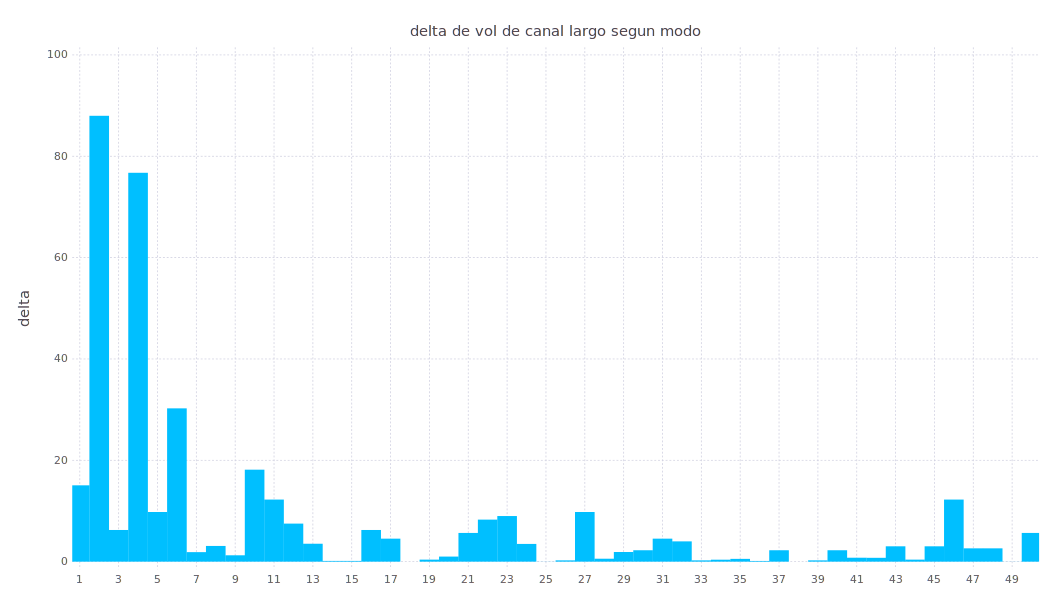

In [115]:
df_vec_pocket_mto_3 = DataFrame(delta = vec_pocket_mto_3)
plot(df_vec_pocket_mto_3,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo"),
Coord.Cartesian(xmin=1, xmax=50),
Guide.xticks(ticks = collect(1:2:50), orientation=:horizontal))

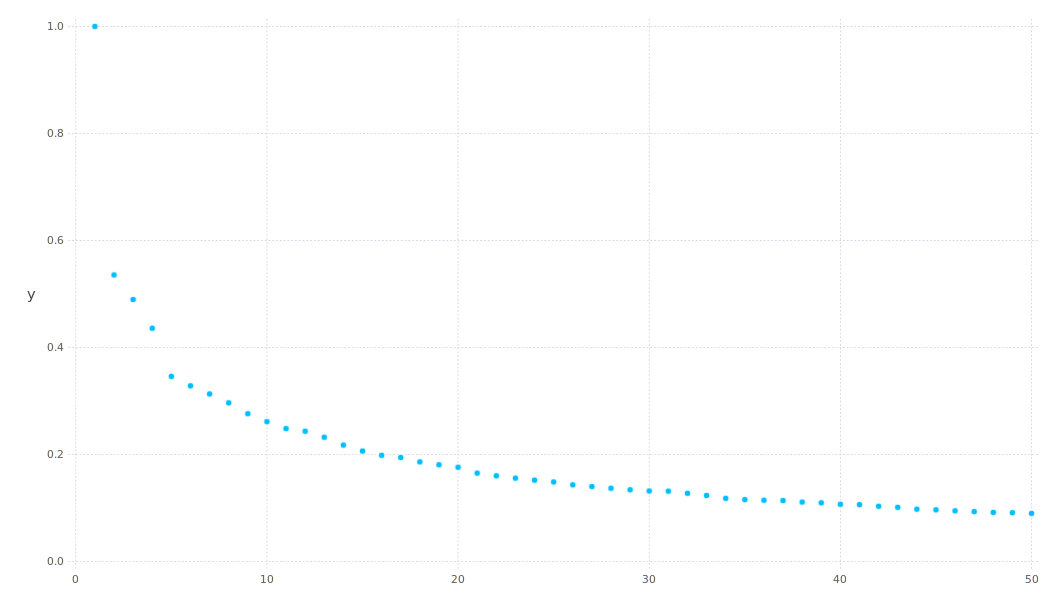

In [124]:
plot(y=(1./(evals_mto[1:50]/evals_mto[1])))

## mtn

## tfo